In [1]:
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
position = 0  # initial position is neutral

### Read data

In [3]:
df = pd.read_excel('TATASTEEL.xlsx', index_col=0)  # first column is index
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)  # convert to datetime, remove timezone
df

,timestamp,open,high,low,close,volume
0.0,2021-08-23 14:11:00,1380.35,1381.00,1379.35,1380.25,15564.0
1.0,2021-08-23 14:12:00,1380.50,1381.00,1379.25,1379.80,28503.0
2.0,2021-08-23 14:13:00,1379.80,1380.55,1378.05,1378.80,29879.0
3.0,2021-08-23 14:14:00,1378.80,1378.80,1377.15,1378.00,16814.0
4.0,2021-08-23 14:15:00,1378.30,1378.70,1375.35,1376.25,36478.0
...,...,...,...,...,...,...
8620.0,2021-09-24 14:06:00,1261.95,1262.70,1260.00,1260.15,65604.0
8621.0,2021-09-24 14:07:00,1260.15,1261.00,1259.05,1259.70,107859.0
8622.0,2021-09-24 14:08:00,1259.95,1260.35,1258.45,1259.95,54899.0
8623.0,2021-09-24 14:09:00,1260.20,1261.85,1259.25,1261.65,49614.0


### Sub-task a.

In [4]:
def SMA(df_column, n):
    """Simple Moving Average, returned as a numpy array"""
    sma = np.zeros(len(df_column))

    sum = 0
    for i in range(len(df_column)):
        sum += df_column[i]

        if i >= n:
            sum -= df_column[i - n]
        
        sma[i] = sum / min(i + 1, n)

    return sma

In [5]:
df['fast SMA'] = SMA(df['close'], 7)
df['slow SMA'] = SMA(df['close'], 20)
df.head()

,timestamp,open,high,low,close,volume,fast SMA,slow SMA
0.0,2021-08-23 14:11:00,1380.35,1381.00,1379.35,1380.25,15564.0,1380.250000,1380.250000
1.0,2021-08-23 14:12:00,1380.50,1381.00,1379.25,1379.80,28503.0,1380.025000,1380.025000
2.0,2021-08-23 14:13:00,1379.80,1380.55,1378.05,1378.80,29879.0,1379.616667,1379.616667
3.0,2021-08-23 14:14:00,1378.80,1378.80,1377.15,1378.00,16814.0,1379.212500,1379.212500
4.0,2021-08-23 14:15:00,1378.30,1378.70,1375.35,1376.25,36478.0,1378.620000,1378.620000


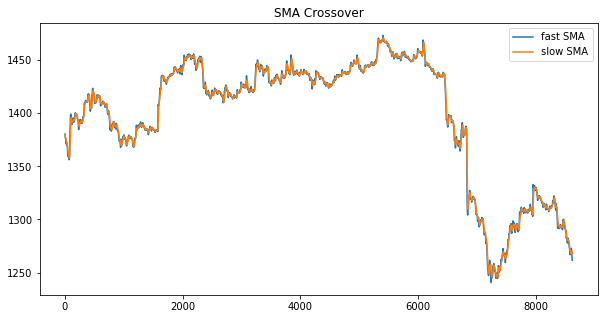

In [6]:
df.plot(y=['fast SMA', 'slow SMA'], title='SMA Crossover', figsize=(10, 5));

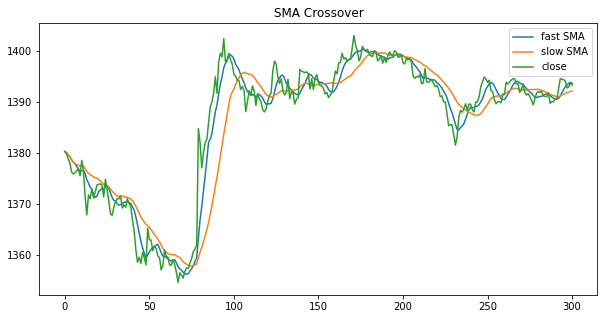

In [7]:
# zoomed in on first 300 timestamps for better visualization
df[:300].plot(y=['fast SMA', 'slow SMA', 'close'], title='SMA Crossover', figsize=(10, 5));

### Sub-task b.

In [8]:
def S1(df):
    """Support 1 (related to Pivot Points), returns a numpy array"""
    s1 = np.zeros(len(df))

    P = (df['high'] + df['low'] + df['close']) / 3
    s1 = 2 * P - df['high']
    
    return s1.shift(periods=1, fill_value=0)  # shift down by 1

In [9]:
df['S1'] = S1(df)
df.head()

,timestamp,open,high,low,close,volume,fast SMA,slow SMA,S1
0.0,2021-08-23 14:11:00,1380.35,1381.00,1379.35,1380.25,15564.0,1380.250000,1380.250000,0.000000
1.0,2021-08-23 14:12:00,1380.50,1381.00,1379.25,1379.80,28503.0,1380.025000,1380.025000,1379.400000
2.0,2021-08-23 14:13:00,1379.80,1380.55,1378.05,1378.80,29879.0,1379.616667,1379.616667,1379.033333
3.0,2021-08-23 14:14:00,1378.80,1378.80,1377.15,1378.00,16814.0,1379.212500,1379.212500,1377.716667
4.0,2021-08-23 14:15:00,1378.30,1378.70,1375.35,1376.25,36478.0,1378.620000,1378.620000,1377.166667


In [10]:
cost = 0
result = 100

for i in range(1, len(df)):  # skip first row (no previous data for calculating S1)
    if position == 0:  # neutral
        if df['close'][i] > df['S1'][i] and df['close'][i] > df['slow SMA'][i]:
            position = 1  # buy
            cost = df['close'][i]
    else:  # position = 1
        if df['close'][i] < df['S1'][i] and df['close'][i] < df['slow SMA'][i]:
            position = 0  # sell
            result *= df['close'][i] / cost

if result >= 100:
    print(f"Total Profit of the entire Backtest = {result - 100:.2f}%")
else:
    print(f"Total Loss of the entire Backtest = {100 - result:.2f}%")

Total Loss of the entire Backtest = 11.34%


### Sub-task c.

In [11]:
cost = 0
result = 100

for i in range(1, len(df)):
    if position == 0:  
        if df['close'][i] > df['S1'][i] and df['close'][i] > df['slow SMA'][i]:
            position = 1
            cost = df['close'][i]
    else:  # position = 1
        if (df['close'][i] < df['S1'][i] and df['close'][i] < df['slow SMA'][i]
            or df['close'][i] / cost >= (100 + 1) / 100  # target profit of 1%
            or df['close'][i] / cost <= (100 - 0.5) / 100):  # stop loss of 0.5%
                position = 0
                result *= df['close'][i] / cost

if result >= 100:
    print(f"Total Profit of the entire Backtest = {result - 100:.2f}%")
else:
    print(f"Total Loss of the entire Backtest = {100 - result:.2f}%")

Total Loss of the entire Backtest = 8.92%


### Sub-task d.

In [12]:
cost = 0
valuation = np.zeros(len(df))
valuation[0] = 100

for i in range(1, len(df)):
    if position == 0:
        valuation[i] = valuation[i - 1]
        if (df['close'][i] > df['S1'][i] and df['close'][i] > df['slow SMA'][i]
            and df['timestamp'][i].time() >= dt.time(9, 25, 0)):  # only purchase after 9:25am
                position = 1
                cost = df['close'][i]
    else:  # position = 1
        valuation[i] = valuation[i - 1] * df['close'][i] / df['close'][i - 1]
        if (df['close'][i] < df['S1'][i] and df['close'][i] < df['slow SMA'][i]
            or df['close'][i] / cost >= (100 + 1) / 100
            or df['close'][i] / cost <= (100 - 0.5) / 100
            or df['timestamp'][i].time() == dt.time(15, 15, 0)):  # square off by 3:15pm
            position = 0
            
if valuation[-1] >= 100:
    print(f"Total Profit of the entire Backtest = {valuation[-1] - 100:.2f}%")
else:
    print(f"Total Loss of the entire Backtest = {100 - valuation[-1]:.2f}%")

df['valuation'] = valuation  # add valuation column to dataframe

Total Loss of the entire Backtest = 11.65%


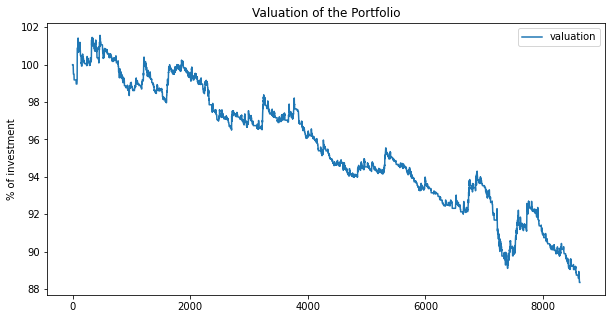

In [13]:
df.plot(y=['valuation'], title='Valuation of the Portfolio', ylabel="% of investment", figsize=(10, 5));